# maxsmi
## Analysis of results

This notebook serves to analyse the results of the simulations ran on the Curta cluster from the Freie Universität Berlin.

Simulations can be run using the following command:
```
(maxsmi) $ python maxsmi/full_workflow.py --task FreeSolv --aug-strategy-train augmentation_maximum_estimation --aug-nb-train 10 --aug-nb-test 10

```

📝 Have a look at the [README](https://github.com/t-kimber/maxsmi/blob/main/README.md) page for more details.

### Goal

The aim of this notebook is to look the results on the test set for
- the ESOL_small and FreeSolv tasks
- the CONV1D model,
- and the estimated maximum augmentation strategy.

More specifically, investigate the number of SMILES generated using this strategy.

In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import dataframe_image as dfi
import matplotlib.pyplot as plt
from maxsmi.utils_analysis import retrieve_metric
from maxsmi.utils_smiles import get_num_heavy_atoms
from rdkit import Chem

In [2]:
# Path to this notebook
HERE = Path(_dh[-1])

path_to_output = HERE.parents[0]

# Make a folder for output figures
os.makedirs(f"{HERE}/figures", exist_ok=True)

## Dataset
We consider the following datasets:

- ESOL_small
- FreeSolv

_Note_: The lipophilicity data set was not run for computational reasons and ESOL_small was used instead of ESOL for the same reason.

_Note_: the data investigated is only the test set (i.e. 20% of the original data). Indeed, saving all SMILES variations generated in the train set would have been too memory intensive.

Comment/uncomment the dataset of choice in the cell below.

In [3]:
TASK = "ESOL_small"
# TASK = "FreeSolv"

In [4]:
MODEL = "CONV1D"

In [5]:
path = (f"{path_to_output}/output/"
        f"{TASK}_smiles_augmentation_maximum_estimation_"
        f"10_augmentation_maximum_estimation_10_{MODEL}")

In [6]:
data = pd.read_pickle(f"{path}/results_ensemble_learning.pkl")
data.head(2)

,target,canonical_smiles,augmented_smiles,new_smiles,average_prediction,std_prediction
397,-5.40,O=C1C2CC=CCC2C(=O)N1SC(Cl)(Cl)C(Cl)Cl,"[S(C(Cl)(Cl)C(Cl)Cl)N1C(=O)C2CC=CCC2C1=O, O=C1...","[S(C(L)(L)C(L)L)N1C(=O)C2CC=CCC2C1=O, O=C1N(C(...",-4.806540,0.224556
688,-3.73,CCCCC1C(=O)N(c2ccccc2)N(c2ccc(O)cc2)C1=O,"[c1(O)ccc(N2N(c3ccccc3)C(C(C2=O)CCCC)=O)cc1, C...","[c1(O)ccc(N2N(c3ccccc3)C(C(C2=O)CCCC)=O)cc1, C...",-4.266408,0.298026


#### Number of heavy atoms per compound

In [7]:
data["nb_heavy_atoms"] = data.canonical_smiles.apply(get_num_heavy_atoms)

#### Number of generated SMILES (unique) per compound using estimated maximum strategy

Note: the generated SMILES with this strategy are unique.

In [8]:
def number_of_smiles_per_compound(list_):
    return len(list_)

In [9]:
data["nb_smiles_generated"] = data.augmented_smiles.apply(number_of_smiles_per_compound)

### Molecule with the largest number of generated SMILES

Maximum number of generated SMILES: 50659
given by canonical SMILES: CC(=O)C1(C)CCC2C3C=C(C)C4=CC(=O)CCC4(C)C3CCC21C
With 25 heavy atoms


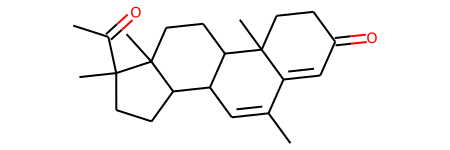

In [10]:
print(f"Maximum number of generated SMILES: {max(data['nb_smiles_generated'])}")
print(f"given by canonical SMILES: {data.canonical_smiles[data['nb_smiles_generated'].idxmax()]}")
print(f"With {data.nb_heavy_atoms[data['nb_smiles_generated'].idxmax()]} heavy atoms")

molecule = Chem.MolFromSmiles(data.canonical_smiles[data['nb_smiles_generated'].idxmax()])
molecule

### Molecule with the smallest number of generated SMILES

Minimum number of generated SMILES: 3
given by canonical SMILES: C=CC=C
With 4 heavy atoms
['C(=C)C=C', 'C(C=C)=C', 'C=CC=C']


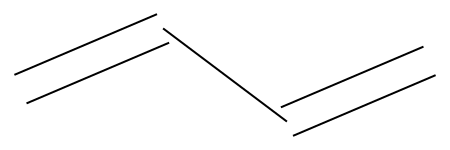

In [11]:
print(f"Minimum number of generated SMILES: {min(data['nb_smiles_generated'])}")
print(f"given by canonical SMILES: {data.canonical_smiles[data['nb_smiles_generated'].idxmin()]}")
print(f"With {data.nb_heavy_atoms[data['nb_smiles_generated'].idxmin()]} heavy atoms")
molecule = Chem.MolFromSmiles(data.canonical_smiles[data['nb_smiles_generated'].idxmin()])
print(data.augmented_smiles[data['nb_smiles_generated'].idxmin()])
molecule

#### Histogram of number of generated SMILES per compound

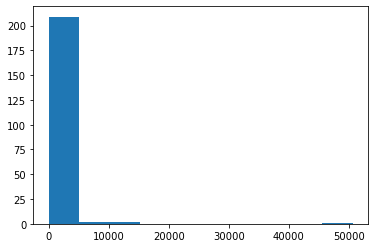

In [12]:
plt.hist(data["nb_smiles_generated"])
plt.show()

#### Scatter plot of number of generated SMILES per compound vs. the number of heavy atom per compound

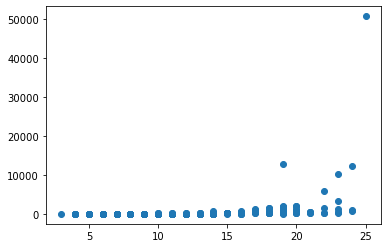

In [13]:
plt.scatter(data["nb_heavy_atoms"], data["nb_smiles_generated"])
plt.show()

#### Mean/median number of generated SMILES per compound

In [14]:
mean_nb_smiles = data['nb_smiles_generated'].mean()
print(f"Mean: {mean_nb_smiles:.3f}")

Mean: 677.332


In [15]:
median_nb_smiles = data['nb_smiles_generated'].median()
print(f"Median: {median_nb_smiles:.3f}")

Median: 73.500


#### Standard deviation in the number of generated SMILES per compound

In [16]:
std_dev_nb_smiles = data['nb_smiles_generated'].std()
print(f"Standard deviation: {std_dev_nb_smiles:.3f}")

Standard deviation: 3737.942


### Removing the most extreme value (outlier)

Let's remove the outlier with 25 heavy atoms:

In [17]:
data.shape

(214, 8)

In [18]:
data_restricted = data.drop([data['nb_smiles_generated'].idxmax()])
data_restricted.shape

(213, 8)

#### Histogram of number of generated SMILES per compound

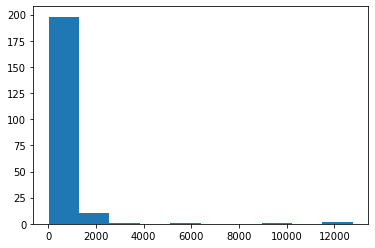

In [19]:
plt.hist(data_restricted["nb_smiles_generated"])
plt.show()

#### Scatter plot of number of generated SMILES per compound vs. the number of heavy atom per compound

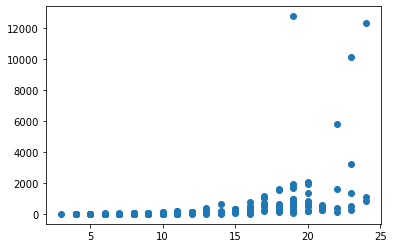

In [20]:
plt.scatter(data_restricted["nb_heavy_atoms"], data_restricted["nb_smiles_generated"])
plt.show()

#### Mean/median number of generated SMILES per compound

In [21]:
mean_nb_smiles = data_restricted['nb_smiles_generated'].mean()
print(f"Mean: {mean_nb_smiles:.3f}")

Mean: 442.676


In [22]:
median_nb_smiles = data_restricted['nb_smiles_generated'].median()
print(f"Median: {median_nb_smiles:.3f}")

Median: 71.000


In [23]:
std_dev_nb_smiles = data_restricted['nb_smiles_generated'].std()
print(f"Standard deviation: {std_dev_nb_smiles:.3f}")

Standard deviation: 1482.899
